# Project Summary
The used car market has experienced significant growth over the years. Amid the pandemic, a notable shift was observed where approximately 61% of car buyers expressed a preference for purchasing from dealerships.

Interestingly, data indicates that the total sales of pre-owned vehicles in the US have doubled compared to new car sales. This trend underscores the vast array of options available to prospective buyers in the used car market.

This analysis aims to delve into historical buyer preferences and explore how these insights can be harnessed to enhance the Craigslist algorithm, thereby facilitating both buyers and sellers.
# Project Objective
The primary objective of this project is to develop a predictive model for used car prices. This model will serve as a valuable tool for buyers and sellers, providing an estimated price range for specific car models and features.
# Data Collection
The dataset for this analysis was meticulously compiled by data contributor Austin Reese and is available on the Kaggle website. The dataset encompasses all pertinent information provided by Craigslist on car sales across the United States. This includes details such as vehicle price, condition, manufacturer, location, among 16 other categories.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mstats

from sklearn.linear_model import LinearRegression
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
### Printing summary of raw data
print("Total Number of Entries =",len(df))
df.columns

Total Number of Entries = 426880


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

# Preprocessing our data

In [6]:
# Removing unimportant columns and check the row count
df.drop(['id', 'region_url', 'VIN', 'url', 'description', 'county'], axis=1, inplace=True)
df.shape

(426880, 20)

In [7]:
df.duplicated().value_counts()

False    426845
True         35
Name: count, dtype: int64

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(426845, 20)

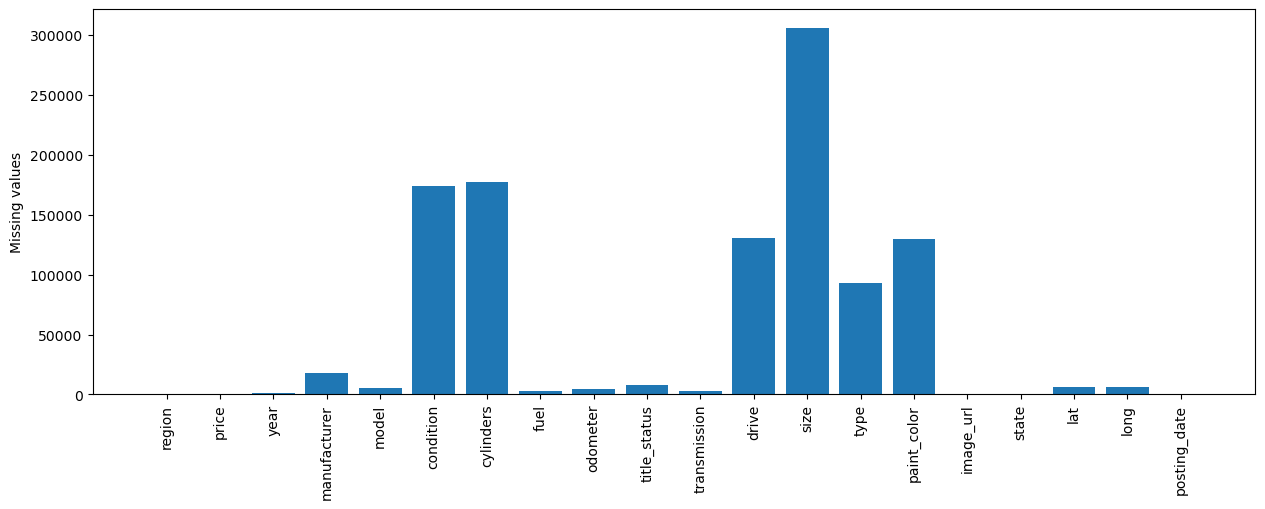

In [9]:
#Let's visualize the missing data
plt.figure(figsize = (15,5))
# Bar plot of missing values
plt.bar(df.columns,df.isna().sum())
plt.ylabel('Missing values')
plt.xticks(rotation=90)
plt.show()

Text(0.5, -0.25, 'Fig: Heatmap to visualize the number of null values in each column')

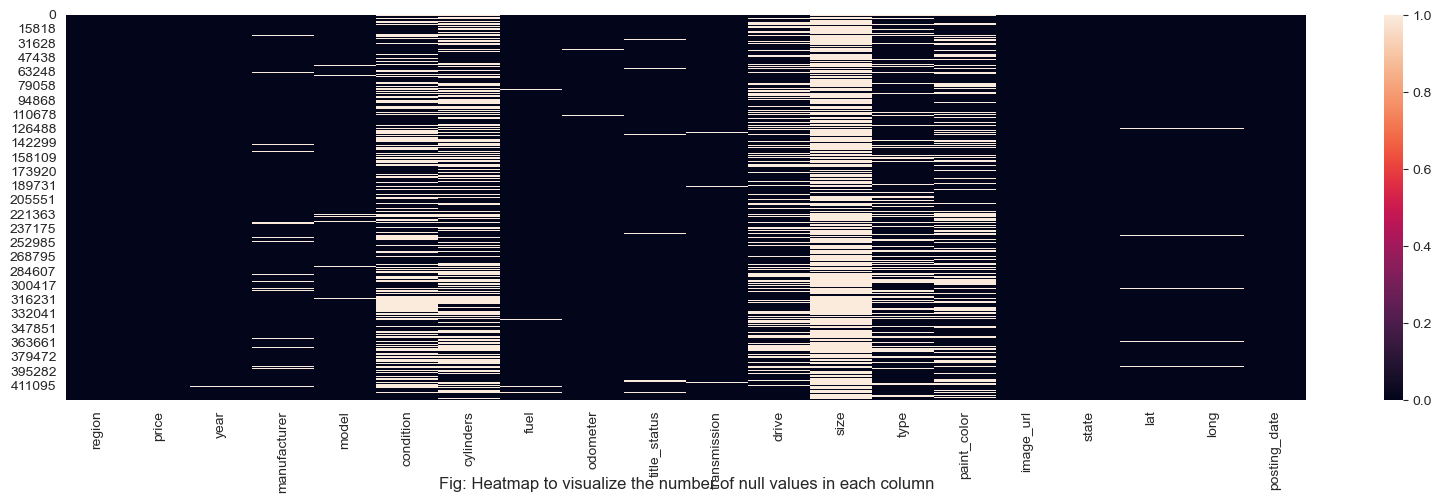

In [10]:
plt.figure(figsize = (20, 5))
sns.set_style("darkgrid")
sns.heatmap(df.isnull())
plt.title('Fig: Heatmap to visualize the number of null values in each column', y=-0.25)

In [11]:
df.isna().sum()

region               0
price                0
year              1194
manufacturer     17635
model             5266
condition       174084
cylinders       177658
fuel              3002
odometer          4389
title_status      8221
transmission      2545
drive           130550
size            306329
type             92847
paint_color     130181
image_url           57
state                0
lat               6538
long              6538
posting_date        57
dtype: int64

Visualizing the missing data, we see that there are quite a number of columns with a lot of missing data. Namely: size, condition, cylinders, drive, paint_color, and type. Since more than 75% of values in the size column is missing, it will be removed.

In [12]:
#Remove size column and replot
df.drop(['size'],axis=1,inplace=True)

In [13]:
#drop rows with missing values in year, model, fuel, odometer, transmission
df.dropna(subset=['year','model','fuel','odometer','transmission'],axis=0,inplace=True)
df.shape

(412348, 19)

In [14]:
#drop all concurrent missing values in manufacturer, condition, cylinders, title status, drive, type, paint color, lat and long 
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color', 'lat', 'long'], axis=0, how='all', inplace=True)
df.shape

(412348, 19)

In [15]:
#keep rows with at least 7 non-NA values
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color', 'lat', 'long'], axis=0, thresh=7, inplace=True)
df.shape

(302565, 19)

Note that in the box plot below, the plots are extremly skewed becuase of the outliers in the price feature.

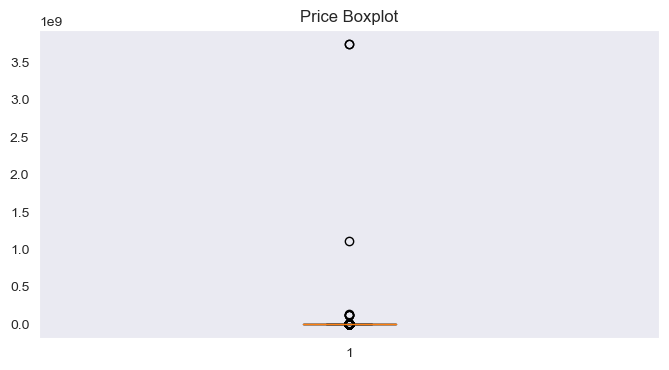

In [16]:
# Create a boxplot for the 'price' column
plt.figure(figsize=(8, 4))
plt.boxplot(df['price'])
plt.title('Price Boxplot')
plt.grid(False)
plt.show()

<Figure size 1600x500 with 0 Axes>

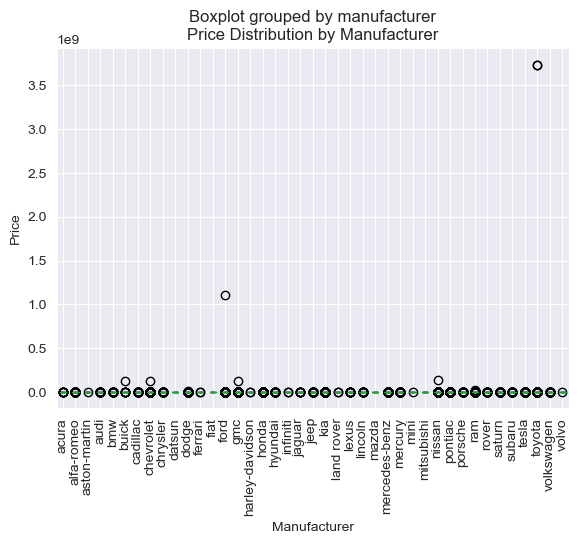

In [17]:
# Create boxplot
plt.figure(figsize=(16, 5))
df.boxplot(column='price', by='manufacturer')
plt.grid(True)
plt.xticks(rotation=90)
plt.title('Price Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()

# High price strangely related to ford and toyota. This might be due to erorr in data enrty or scraping because these manufacturers are 
#not known for high end luxury or sporting cars


In [18]:
# checking for values in 5th percentile and 95th percentile
percentile_5 = df['price'].quantile(0.05)
percentile_95 = df['price'].quantile(0.95)

print("The 5th percentile : ", percentile_5)
print("The 95th percentile : ", percentile_95)

The 5th percentile :  0.0
The 95th percentile :  43980.79999999999


The 95th percentile value is too low. That means majority of data lies from USD 1000 to  USD 50,000. But we have some of the car values in millions.

In [19]:
# prompt: find the records pwhere price > 1000000

outliers_price = df[df['price'] > 1000000]
print(outliers_price)

                         region       price    year manufacturer  \
29386           humboldt county  1111111111  1999.0         ford   
68935            ventura county     2000000  2002.0       saturn   
105843                  orlando     6995495  2014.0        dodge   
136516  spokane / coeur d'alene    17000000  2007.0          ram   
137807  spokane / coeur d'alene   123456789  1999.0        buick   
155421              terre haute     1234567  2006.0         jeep   
193736                ann arbor   123456789  2015.0    chevrolet   
194292                ann arbor     1234567  2010.0      lincoln   
207080                 muskegon   123456789  2003.0          NaN   
219241             southwest MS     1111111  1970.0        dodge   
230753                asheville   135008900  2008.0       nissan   
307488               stillwater   123456789  1996.0          gmc   
318592                   eugene  3736928711  2007.0       toyota   
327938        altoona-johnstown     3226714  200

From the data itself we can see this is false information poised on Craigslist website from where the data was scraped.

In [20]:
# removing the records where price is zero

df = df[df['price'] >= 100]

In [21]:
# prompt: remove the record where  the price > 1000000

df = df[df['price'] < 1000000]

In [22]:
# applying log transformation on price

import numpy as np
# Apply log transformation on price
df['price'] = np.log(df['price'])

# # Inverse transformation
# def inverse_log_transform(log_price):
#   return np.exp(log_price)

<Axes: xlabel='price'>

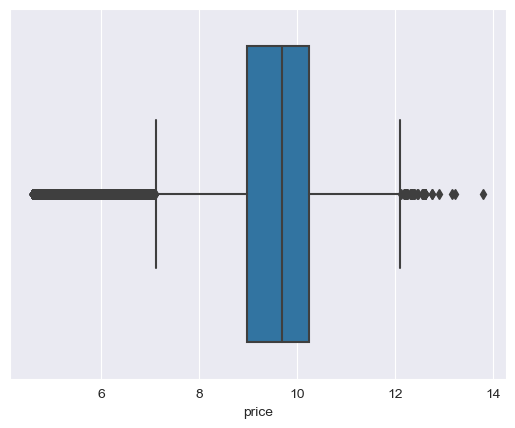

In [23]:
sns.boxplot(x=df['price'])

<Figure size 1600x500 with 0 Axes>

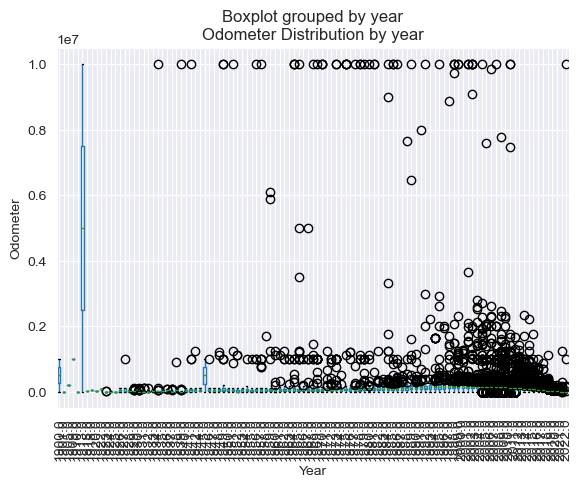

In [24]:
# Create boxplot
plt.figure(figsize=(16, 5))
df.boxplot(column='odometer', by='year')
plt.grid(True)
plt.xticks(rotation=90)
plt.title('Odometer Distribution by year')
plt.xlabel('Year')
plt.ylabel('Odometer')
plt.show()

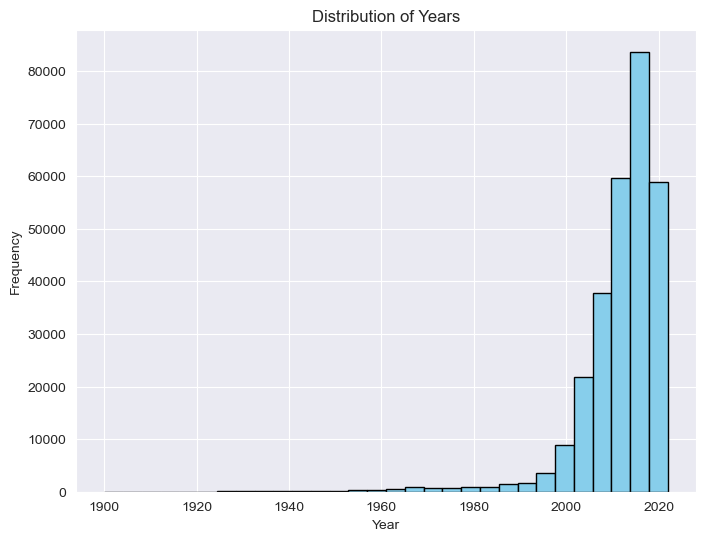

In [25]:
# Create histogram for 'year' column
plt.figure(figsize=(8, 6))
plt.hist(df['year'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [26]:
# checking for values in 5th percentile and 95th percentile
percentile_5 = df['year'].quantile(0.05)
percentile_95 = df['year'].quantile(0.95)

print("The 5th percentile : ", percentile_5)
print("The 95th percentile : ", percentile_95)

The 5th percentile :  1999.0
The 95th percentile :  2020.0


In [27]:
# applying Winsorization method
df['year'] = mstats.winsorize(df['year'], limits=(None, 0.03))

In [28]:
# substract the year column by year 2023 and rewrite the year column in df

df['age'] = 2023 - df['year']
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,image_url,state,lat,long,posting_date,age
27,auburn,10.421984,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,al,32.590,-85.4800,2021-05-04T12:31:18-0500,9.0
28,auburn,10.025263,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,al,32.590,-85.4800,2021-05-04T12:31:08-0500,13.0
29,auburn,10.586332,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,al,32.590,-85.4800,2021-05-04T12:31:25-0500,3.0
30,auburn,10.341420,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,al,32.590,-85.4800,2021-05-04T10:41:31-0500,6.0
31,auburn,9.615805,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,al,32.592,-85.5189,2021-05-03T14:02:03-0500,10.0


In [29]:
# checking for values in 5th percentile and 95th percentile
percentile_5 = df['odometer'].quantile(0.05)
percentile_95 = df['odometer'].quantile(0.95)

print("The 5th percentile : ", percentile_5)
print("The 95th percentile : ", percentile_95)

The 5th percentile :  7512.0
The 95th percentile :  203051.69999999995


Findings:

+ There is no outliers on extreme low.
+ The 95th percentile starts from 206000 km but outlier through IQR starts from 277302 km. So we will match the percentile and outlier and then apply Winsorization only to the upper extreme values.  Winsorization is a method that replaces extreme values with less extreme values.

In [30]:
# applying Winsorization method
df['odometer'] = mstats.winsorize(df['odometer'], limits=(None, 0.02))

In [31]:
df.isna().sum()

region              0
price               0
year                0
manufacturer     7939
model               0
condition       67290
cylinders       71208
fuel                0
odometer            0
title_status     2520
transmission        0
drive           40971
type            18966
paint_color     39187
image_url           0
state               0
lat               516
long              516
posting_date        0
age                 0
dtype: int64

In [32]:
df.dropna(subset=['lat','long'],axis=0,inplace=True)
df.shape

(282698, 20)

In [33]:
df.cylinders.replace("other",np.nan,inplace=True)
df.cylinders.value_counts()

cylinders
6 cylinders     80949
4 cylinders     66110
8 cylinders     60243
5 cylinders      1550
10 cylinders     1067
3 cylinders       535
12 cylinders      158
Name: count, dtype: int64

In [34]:
# Replace 'cylinders ' from string values in the 'cylinders' column
df['cylinders'] = df['cylinders'].apply(lambda x: x.replace(' cylinders', '') if isinstance(x, str) else x)

In [35]:
# code to replace object type into int type in cylinders column without touching missing values

df['cylinders'] = df['cylinders'].apply(pd.to_numeric, errors='ignore')

In [36]:
df.cylinders.value_counts()

cylinders
6.0     80949
4.0     66110
8.0     60243
5.0      1550
10.0     1067
3.0       535
12.0      158
Name: count, dtype: int64

In [37]:
df.manufacturer.value_counts()

manufacturer
ford               45749
chevrolet          35813
toyota             24299
honda              14622
jeep               13583
nissan             12786
ram                11750
gmc                11358
bmw                 9538
dodge               8570
volkswagen          6946
mercedes-benz       6872
hyundai             6695
subaru              6225
lexus               6018
kia                 5479
audi                5389
cadillac            4945
acura               4662
chrysler            3968
mazda               3909
buick               3729
infiniti            3657
lincoln             3061
mitsubishi          2445
volvo               2380
mini                1674
jaguar              1498
pontiac             1454
rover               1258
mercury              824
porsche              785
saturn               685
tesla                684
alfa-romeo           657
fiat                 621
harley-davidson       53
ferrari               50
datsun                42
aston-martin

In [38]:
# removing the record if manufacturer_counts <1000 from df
manufacturer_counts = df['manufacturer'].value_counts()
df = df[df['manufacturer'].isin(manufacturer_counts[manufacturer_counts > 1000].index)]

In [39]:
# categorical columns

categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
print(categorical_cols)

['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'image_url', 'state', 'posting_date']


In [40]:
# prompt: find the unique values of all the columns in list categorical_cols

for col in categorical_cols:
  unique_values = df[col].unique()
  print(f"Unique values for column '{col}': {unique_values}")

Unique values for column 'region': ['auburn' 'birmingham' 'dothan' 'florence / muscle shoals'
 'gadsden-anniston' 'huntsville / decatur' 'mobile' 'montgomery'
 'tuscaloosa' 'anchorage / mat-su' 'fairbanks' 'kenai peninsula'
 'southeast alaska' 'flagstaff / sedona' 'mohave county' 'phoenix'
 'prescott' 'show low' 'sierra vista' 'tucson' 'yuma' 'fayetteville'
 'fort smith' 'jonesboro' 'little rock' 'texarkana' 'bakersfield' 'chico'
 'fresno / madera' 'gold country' 'hanford-corcoran' 'humboldt county'
 'imperial county' 'inland empire' 'los angeles' 'mendocino county'
 'merced' 'modesto' 'monterey bay' 'orange county' 'palm springs'
 'redding' 'reno / tahoe' 'sacramento' 'san diego' 'san luis obispo'
 'santa barbara' 'santa maria' 'SF bay area' 'siskiyou county' 'stockton'
 'susanville' 'ventura county' 'visalia-tulare' 'yuba-sutter' 'boulder'
 'colorado springs' 'denver' 'eastern CO' 'fort collins / north CO'
 'high rockies' 'pueblo' 'western slope' 'eastern CT' 'hartford'
 'new haven' 

In [41]:
df.type.replace("other",np.nan,inplace=True)
df.type.value_counts()

type
sedan          65445
SUV            59617
pickup         35818
truck          26974
coupe          14389
hatchback      11976
wagon           7971
van             6291
convertible     5387
mini-van        3889
offroad          525
bus              220
Name: count, dtype: int64

In [42]:
df.title_status.replace("missing",np.nan,inplace=True)
df.title_status.value_counts()

title_status
clean         258476
rebuilt         5275
salvage         2555
lien            1151
parts only        77
Name: count, dtype: int64

In [43]:
df.condition.replace("other",np.nan,inplace=True)
df.condition.value_counts()

condition
good         103791
excellent     77636
like new      16210
fair           5177
new             745
salvage         445
Name: count, dtype: int64

In [44]:
df.transmission.replace("other",np.nan,inplace=True)
df.transmission.value_counts()

transmission
automatic    203076
manual        14320
Name: count, dtype: int64

In [45]:
df.paint_color.replace("other",np.nan,inplace=True)
df.paint_color.value_counts()

paint_color
white     59312
black     49776
silver    33994
blue      24647
red       24073
grey      20257
green      5619
custom     5530
brown      5427
orange     1482
yellow     1480
purple      530
Name: count, dtype: int64

In [46]:
df.drive.replace("other",np.nan,inplace=True)
df.drive.value_counts()

drive
4wd    102402
fwd     84007
rwd     44390
Name: count, dtype: int64

## Handling the missing values

In [47]:
#normalize the type value counts and save into a dataframe
type_prob = pd.DataFrame(list(df.type.value_counts(normalize=True).items()),columns = ['type','prob'])
#substitute missing values in title_status to random states based on their probabilities
df.loc[df.type.isna(), 'type'] = np.random.choice(type_prob.type, 
                                                size=df.type.isna().sum(),
                                                replace=True, 
                                                p=type_prob.prob)

In [48]:
df.type.value_counts()

type
sedan          74268
SUV            67590
pickup         40559
truck          30541
coupe          16259
hatchback      13613
wagon           9037
van             7145
convertible     6067
mini-van        4411
offroad          591
bus              251
Name: count, dtype: int64

In [49]:
#normalize the condition value counts and save into a dataframe
condition_prob = pd.DataFrame(list(df.condition.value_counts(normalize=True).items()),columns = ['condition','prob'])
#substitute missing values in condition to random states based on their probabilities
df.loc[df.condition.isna(), 'condition'] = np.random.choice(condition_prob.condition, 
                                                size=df.condition.isna().sum(),
                                                replace=True, 
                                                p=condition_prob.prob)

In [50]:
df.condition.value_counts()

condition
good         137377
excellent    102827
like new      21626
fair           6879
new            1028
salvage         595
Name: count, dtype: int64

In [51]:
#normalize the drive value counts and save into a dataframe
drive_prob = pd.DataFrame(list(df.drive.value_counts(normalize=True).items()),columns = ['drive','prob'])
#substitute missing values in drive to random states based on their probabilities
df.loc[df.drive.isna(), 'drive'] = np.random.choice(drive_prob.drive, 
                                                size=df.drive.isna().sum(),
                                                replace=True, 
                                                p=drive_prob.prob)

In [52]:
df.drive.value_counts()

drive
4wd    119854
fwd     98360
rwd     52118
Name: count, dtype: int64

In [53]:
#normalize the paint_color value counts and save into a dataframe
paint_color_prob = pd.DataFrame(list(df.paint_color.value_counts(normalize=True).items()),columns = ['paint_color','prob'])
#substitute missing values in paint_color to random states based on their probabilities
df.loc[df.paint_color.isna(), 'paint_color'] = np.random.choice(paint_color_prob.paint_color, 
                                                size=df.paint_color.isna().sum(),
                                                replace=True, 
                                                p=paint_color_prob.prob)

In [54]:
df.paint_color.value_counts()

paint_color
white     69154
black     57922
silver    39665
blue      28705
red       27920
grey      23649
green      6525
custom     6406
brown      6314
yellow     1741
orange     1726
purple      605
Name: count, dtype: int64

In [55]:
#normalize the manufacturer value counts and save into a dataframe
manufacturer_prob = pd.DataFrame(list(df.manufacturer.value_counts(normalize=True).items()),columns = ['manufacturer','prob'])
#substitute missing values in manufacturer to random states based on their probabilities
df.loc[df.manufacturer.isna(), 'manufacturer'] = np.random.choice(manufacturer_prob.manufacturer, 
                                                size=df.manufacturer.isna().sum(),
                                                replace=True, 
                                                p=manufacturer_prob.prob)

In [56]:
#normalize the cylinders value counts and save into a dataframe
cylinders_prob = pd.DataFrame(list(df.cylinders.value_counts(normalize=True).items()),columns = ['cylinders','prob'])
#substitute missing values in cylinders to random states based on their probabilities
df.loc[df.cylinders.isna(), 'cylinders'] = np.random.choice(cylinders_prob.cylinders, 
                                                size=df.cylinders.isna().sum(),
                                                replace=True, 
                                                p=cylinders_prob.prob)

In [57]:
#normalize the transmission value counts and save into a dataframe
transmission_prob = pd.DataFrame(list(df.transmission.value_counts(normalize=True).items()),columns = ['transmission','prob'])
#substitute missing values in transmission to random states based on their probabilities
df.loc[df.transmission.isna(), 'transmission'] = np.random.choice(transmission_prob.transmission, 
                                                size=df.transmission.isna().sum(),
                                                replace=True, 
                                                p=transmission_prob.prob)

In [58]:
#normalize the title_status value counts and save into a dataframe
title_status_prob = pd.DataFrame(list(df.title_status.value_counts(normalize=True).items()),columns = ['title_status','prob'])
#substitute missing values in title_status to random states based on their probabilities
df.loc[df.title_status.isna(), 'title_status'] = np.random.choice(title_status_prob.title_status, 
                                                size=df.title_status.isna().sum(),
                                                replace=True, 
                                                p=title_status_prob.prob)

In [59]:
df.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
image_url       0
state           0
lat             0
long            0
posting_date    0
age             0
dtype: int64

In [60]:
#save data to new file
df.to_csv('clean_vehicle.csv',index=False)

In [61]:
#Remove unnecessary columns
df.drop(['lat', 'long', 'posting_date', 'image_url'],axis=1,inplace=True)

# Feature Engineering

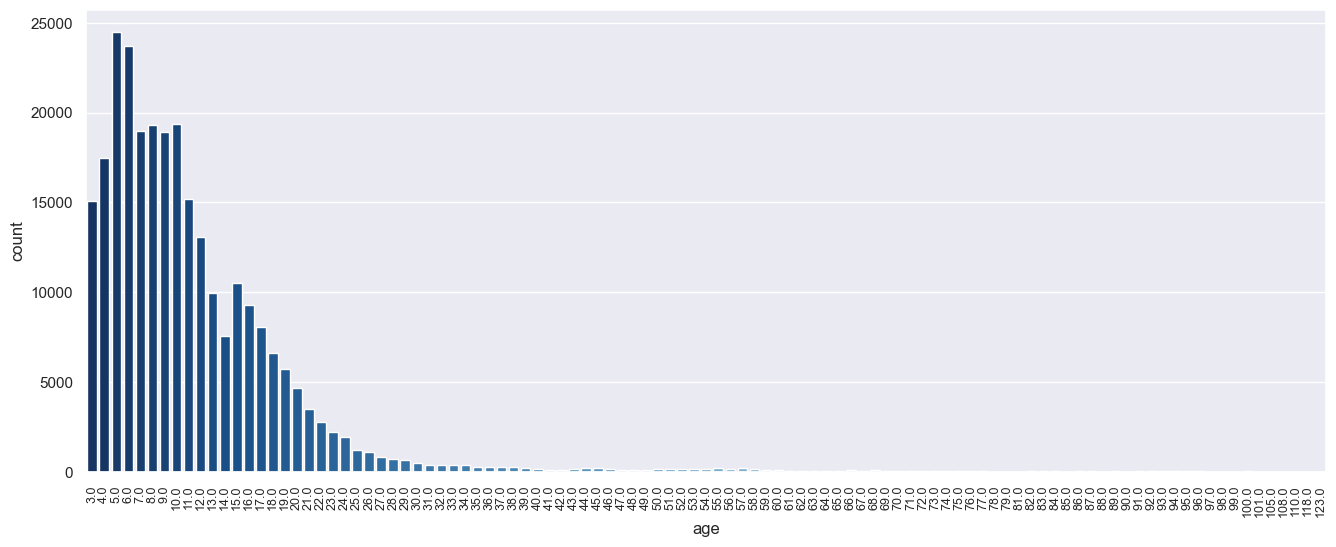

In [62]:
#plot Age distribution
plt.figure(figsize=(16,6))
sns.set()
sns.countplot(x='age',data=df,palette='Blues_r')
plt.xticks(fontsize=9,rotation=90)
plt.show()

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Define numeric features
numeric_features = ['year', 'age', 'price', 'odometer', 'cylinders']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize numeric features
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Check the changes
print("Normalized numeric features:")
print(df[numeric_features].head())

Normalized numeric features:
        year       age     price  odometer  cylinders
27  0.950000  0.050000  0.632242  0.241346   0.555556
28  0.916667  0.083333  0.589122  0.296788   0.555556
29  1.000000  0.000000  0.650106  0.079833   0.555556
30  0.975000  0.025000  0.623486  0.171350   0.555556
31  0.941667  0.058333  0.544617  0.533333   0.333333


In [64]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age
27,auburn,0.632242,0.950000,gmc,sierra 1500 crew cab slt,good,0.555556,gas,0.241346,clean,automatic,rwd,pickup,white,al,0.050000
28,auburn,0.589122,0.916667,chevrolet,silverado 1500,good,0.555556,gas,0.296788,clean,automatic,rwd,pickup,blue,al,0.083333
29,auburn,0.650106,1.000000,chevrolet,silverado 1500 crew,good,0.555556,gas,0.079833,clean,automatic,4wd,pickup,red,al,0.000000
30,auburn,0.623486,0.975000,toyota,tundra double cab sr,good,0.555556,gas,0.171350,clean,automatic,4wd,pickup,red,al,0.025000
31,auburn,0.544617,0.941667,ford,f-150 xlt,excellent,0.333333,gas,0.533333,clean,automatic,rwd,truck,black,al,0.058333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,0.593830,0.991667,nissan,maxima s sedan 4d,good,0.333333,gas,0.134275,clean,automatic,fwd,sedan,red,wy,0.008333
426876,wyoming,0.622074,1.000000,volvo,s60 t5 momentum sedan 4d,good,0.333333,gas,0.050121,clean,automatic,fwd,sedan,red,wy,0.000000
426877,wyoming,0.636681,1.000000,cadillac,xt4 sport suv 4d,good,0.333333,diesel,0.017392,clean,automatic,fwd,hatchback,white,wy,0.000000
426878,wyoming,0.616234,0.983333,lexus,es 350 sedan 4d,good,0.333333,gas,0.125467,clean,automatic,fwd,sedan,silver,wy,0.016667


In [65]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Define features and target
categorical_features = ['manufacturer', 'model', 'condition', 'fuel', 'title_status',
                        'transmission', 'drive', 'type', 'paint_color', 'region', 'state']
# Initialize encoders
one_hot_encoders = {}
label_encoders = {}
entity_embedding_features = ['model', 'region', 'state']

## One-hot encoding for categorical features with low-cardinality

In [66]:
# One-hot encode low-cardinality categorical features
for feature in categorical_features:
    if feature not in entity_embedding_features and df[feature].nunique() <= 10:
        # Drop rows with NaN values in the current feature
        df.dropna(subset=[feature], inplace=True)
        
        # Apply one-hot encoding
        one_hot_encoders[feature] = OneHotEncoder(sparse=False, handle_unknown='ignore')
        one_hot_encoded = one_hot_encoders[feature].fit_transform(df[[feature]])
        
        # Create DataFrame from one-hot encoded data
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=[f'{feature}_{cat}' for cat in one_hot_encoders[feature].categories_[0]])
        
        # Concatenate one-hot encoded DataFrame back to the original DataFrame
        df = pd.concat([df.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)
        
        # Drop the original categorical feature column
        df.drop(columns=[feature], inplace=True)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

## Label encoding for categorical features with high-cardinality

In [67]:
# Label encode high-cardinality categorical features
for feature in categorical_features:
    if feature not in entity_embedding_features and feature not in one_hot_encoders:
        label_encoders[feature] = LabelEncoder()
        df[feature] = label_encoders[feature].fit_transform(df[feature])

## Entity embedding for categorical features with high-cardinality

In [68]:
# Entity embedding for high-cardinality categorical features
for feature in entity_embedding_features:
    if feature in categorical_features:
        num_unique_values = df[feature].nunique()
        embedding_dim = min(50, num_unique_values // 2)  # Adjust embedding dimension as needed
        model = Sequential()
        model.add(Embedding(input_dim=num_unique_values, output_dim=embedding_dim))
        # Add the embedding layer to your model architecture

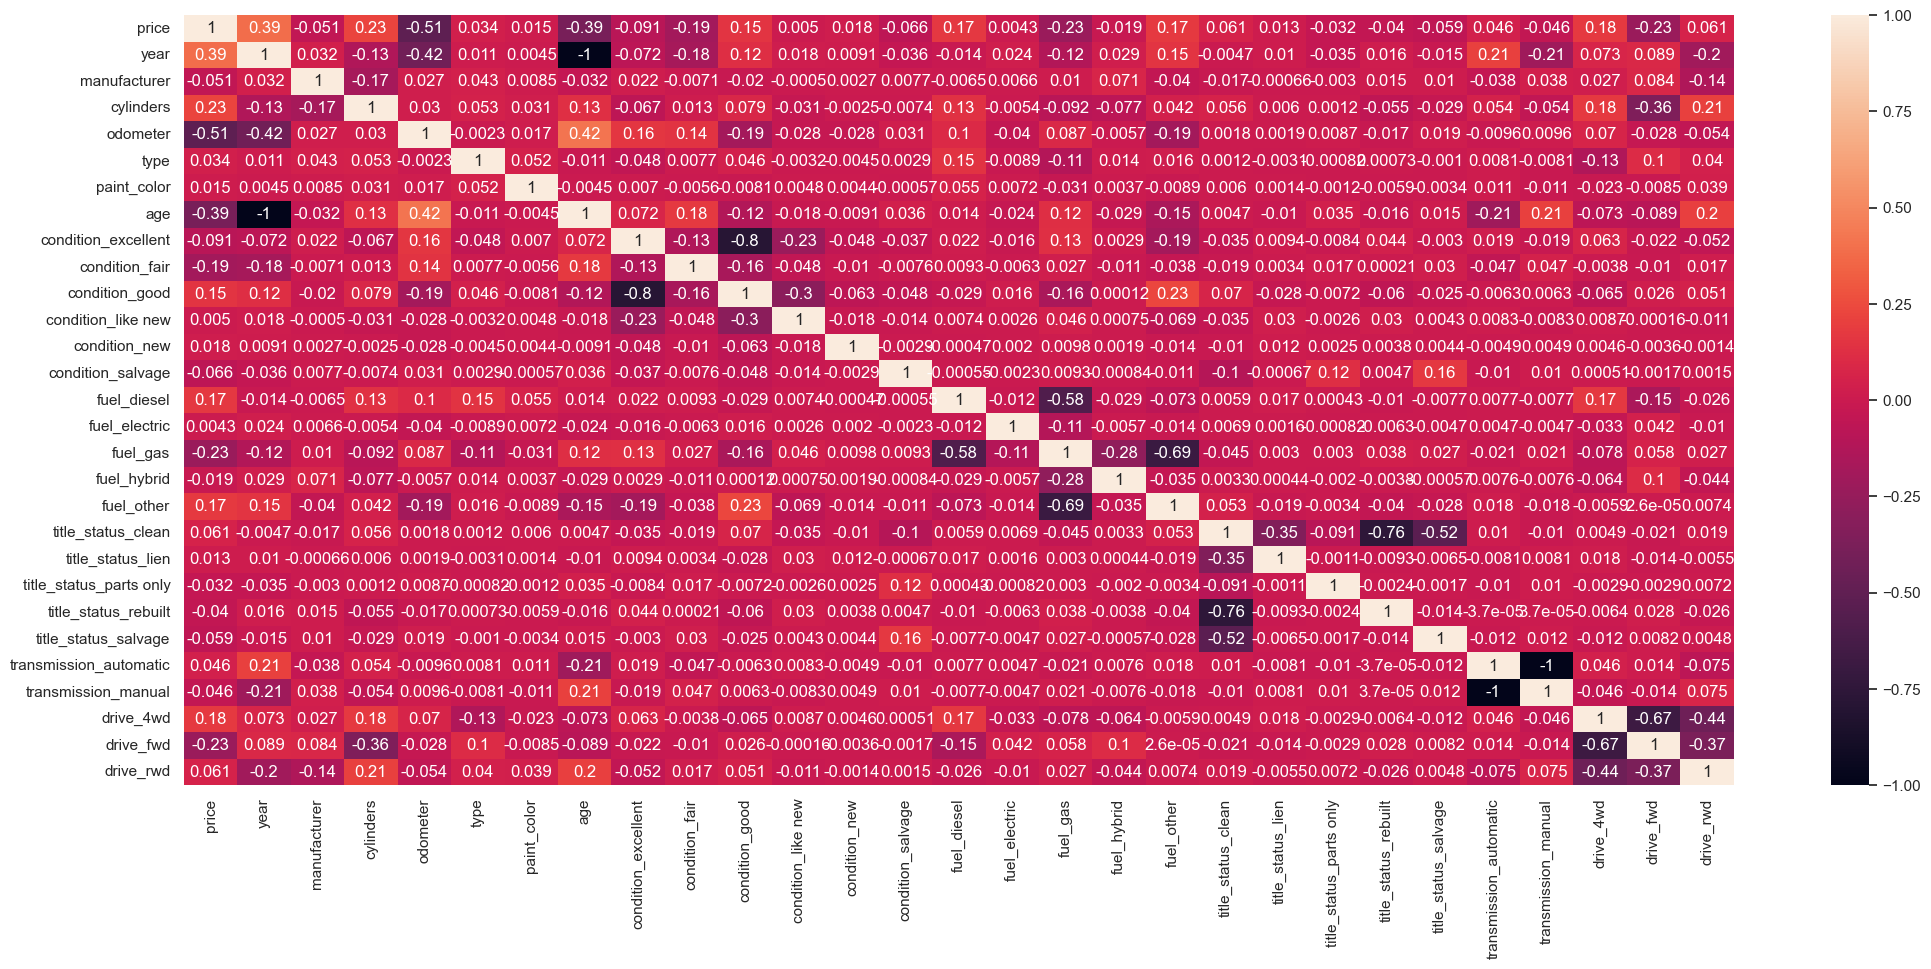

In [69]:
# Select numerical columns
numeric_columns = df.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(25, 10))
sns.heatmap(data=numeric_columns.corr(), annot=True)
plt.show()

In [77]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features and target
features = df.drop(columns=['price'])
target = df['price']

In [78]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Compute class separability using SelectKBest with f_regression scoring
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)

# Get the scores and feature names
feature_scores = pd.DataFrame({'Feature': features.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

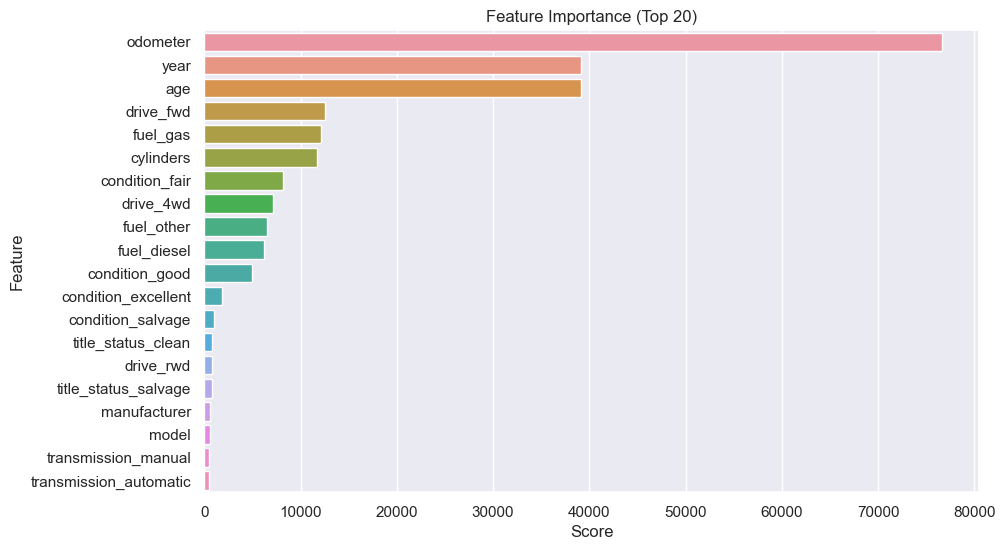

In [79]:
# Visualize class separability
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores[:20])
plt.title('Feature Importance (Top 20)')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Select top features based on SelectKBest
selected_features = feature_scores['Feature'][:10].tolist()

# Train a RandomForestRegressor model using selected features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train[selected_features], y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")